# Imports

In [1]:
# system
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import time
import glob
import datetime as dt
from tqdm import tqdm_notebook

# science
import math
import scipy as sp
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import sklearn
import statsmodels
from fbprophet import Prophet
import scipy.optimize as opt
from sklearn.preprocessing import MinMaxScaler

# visualization
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode()

# logging
import logging
logger = logging.getLogger('root')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)

# profiling
import cProfile
pr = cProfile.Profile()
pr.disable()

# matplotlib plotting style
%matplotlib inline
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Hack'

# seaborn plotting style
sns.set()
sns.set_style('whitegrid')

# setup
#%matplotlib notebook
%reload_ext sql_magic
%config SQL.output_result = False  # disable browser notifications
%config SQL.notify_result = False  # disable output to std out
%reload_ext watermark
%watermark -a 'Ken Cavagnolo' -n -u -v -m -h -g -p jupyter,notebook,pandas,numpy,scipy
rcParams['figure.figsize'] = 15, 6
sns.set_style('whitegrid')
sns.set_context('notebook')
brand_colors = ['#d21e2a', '#ffb619']

Ken Cavagnolo 
last updated: Fri Apr 03 2020 

CPython 3.8.0
IPython 7.11.1

jupyter 1.0.0
notebook 6.0.3
pandas 1.0.3
numpy 1.17.4
scipy 1.4.1

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : DrGonzo.local
Git hash   : a00ba8b145f9384c1b05be576e5132bdadfb517c


# Setup

In [2]:
# reusable data dir
datadir = '../data/'

# Functions

In [156]:
def df_clean_string(df, dtype='object'):
    for col in df.select_dtypes(include=[dtype]).columns:
        if isinstance(df[col][0], str):
            df[col] = df[col].str.lower().str.replace(' ', '_')
    return df

# Geo Data

In [3]:
# read fips county data
fips_datafile = datadir + 'tn/fips.csv'
fips_df = pd.read_csv(fips_datafile, encoding="ISO-8859-1")

# cleanup dataframe
fips_df['county_name'] = fips_df['county_name'].str.lower()
fips_df['state_abbr'] = fips_df['state_abbr'].str.lower()
fips_df['county_name'] = fips_df['county_name'].str.replace(' county', '')

# filter to Tennessee only
fips_df[fips_df['state_abbr'] == 'tn'].head()

fips county_name state_abbr state_name           long_name  sumlev  \
2431  47001    anderson         tn  Tennessee  Anderson County TN    50.0   
2432  47003     bedford         tn  Tennessee   Bedford County TN    50.0   
2433  47005      benton         tn  Tennessee    Benton County TN    50.0   
2434  47007     bledsoe         tn  Tennessee   Bledsoe County TN    50.0   
2435  47009      blount         tn  Tennessee    Blount County TN    50.0   

      region  division  state  county crosswalk region_name  \
2431     3.0       6.0   47.0     1.0  3-6-47-1       South   
2432     3.0       6.0   47.0     3.0  3-6-47-3       South   
2433     3.0       6.0   47.0     5.0  3-6-47-5       South   
2434     3.0       6.0   47.0     7.0  3-6-47-7       South   
2435     3.0       6.0   47.0     9.0  3-6-47-9       South   

           division_name  
2431  East South Central  
2432  East South Central  
2433  East South Central  
2434  East South Central  
2435  East South Central

In [4]:
# read hand-defined "metro area"
metro_datafile = datadir + 'tn/metro.json'

# use the 60min catchment area
drive_time = '60'
with open(metro_datafile) as f:
    metro_data = json.load(f)

# assign metro to fips
knx_metro_fips = []
for county in metro_data[drive_time]:
    knx_metro_fips.append(
        fips_df[(fips_df['county_name'] == county)
                & (fips_df['state_abbr'] == 'tn')]['fips'].values[0])
print('Knoxville Metro FIPS: {}'.format(knx_metro_fips))

Knoxville Metro FIPS: [47001, 47009, 47013, 47025, 47029, 47035, 47057, 47059, 47063, 47089, 47093, 47105, 47107, 47121, 47123, 47129, 47143, 47145, 47151, 47155, 47173]


In [5]:
# read tn hospital data
hospitals_datafile = datadir + 'tn/tn-hospitals.geojson'
hospitals_df = gpd.read_file(hospitals_datafile)

# filter to knx metro
metro_counties = [c for c in metro_data[drive_time]]
knx_hospitals_df = hospitals_df[hospitals_df['County'].str.lower().isin(metro_counties)]
knx_hospitals_df.loc[knx_hospitals_df['icu_beds'] < 0, 'icu_beds'] = 0

# COVID Data

## NYTimes

In [179]:
nytimes_datafile = datadir + 'ny-times/us-counties.csv'
nytimes_df = pd.read_csv(nytimes_datafile)
nytimes_df.fillna(0, inplace=True)
nytimes_df.columns = [c.lower().replace(' ', '_') for c in nytimes_df.columns]
nytimes_df.rename(columns={'cases': 'ncases', 'deaths': 'ndeaths'}, inplace=True)
nytimes_df['date'] = pd.to_datetime(nytimes_df['date'], errors='coerce')
nytimes_df['date'] = nytimes_df.date.dt.date
nytimes_df['fips'] = nytimes_df['fips'].astype('int')
nytimes_df = df_clean_string(nytimes_df)
nytimes_df = nytimes_df.sort_values(by=['date', 'state', 'county'])
nknx_df = nytimes_df[nytimes_df['fips'].isin(knx_metro_fips)]

In [180]:
nknx_df

date     county      state   fips  ncases  ndeaths
1570   2020-03-12       knox  tennessee  47093       1        0
1872   2020-03-13  jefferson  tennessee  47089       1        0
1873   2020-03-13       knox  tennessee  47093       1        0
2234   2020-03-14   campbell  tennessee  47013       1        0
2237   2020-03-14  jefferson  tennessee  47089       1        0
...           ...        ...        ...    ...     ...      ...
28055  2020-04-02       rhea  tennessee  47143       1        0
28056  2020-04-02      roane  tennessee  47145       3        0
28059  2020-04-02      scott  tennessee  47151       3        0
28061  2020-04-02     sevier  tennessee  47155      10        0
28069  2020-04-02      union  tennessee  47173       1        0

[262 rows x 6 columns]

## JHU

In [181]:
jhu_datafiles = glob.glob(os.path.join(datadir, 'jhu_csse/csse_covid_19_data/csse_covid_19_daily_reports/*.csv'))
jhu_df = (pd.read_csv(f) for f in jhu_datafiles)
jhu_df = pd.concat(jhu_df, ignore_index=True)

# data formats changes at some point
#1 - jhu_df.isna().sum().sort_values()/len(jhu_df)

# require this many non-NA values
threshold = 0.75 * len(jhu_df)
jhu_df = jhu_df.dropna(thresh=threshold, axis=1)
threshold = 0.50 * len(jhu_df.columns)
jhu_df = jhu_df.dropna(thresh=threshold, axis=0)
jhu_df = jhu_df.reset_index().drop('index', axis=1)

jhu_df.fillna(0, inplace=True)
jhu_df.columns = [c.lower().replace(' ', '_') for c in jhu_df.columns]
jhu_df.rename(columns={'admin2': 'county', 'confirmed': 'jcases', 'deaths': 'jdeaths'}, inplace=True)
jhu_df['date'] = pd.to_datetime(jhu_df['last_update'], errors='coerce')
jhu_df['date'] = jhu_df.date.dt.date
jhu_df['fips'] = jhu_df['fips'].astype('int')

jhu_df = df_clean_string(jhu_df)
jhu_df = jhu_df.sort_values(by=['date', 'country_region', 'province_state', 'county'])
jknx_df = jhu_df[jhu_df['fips'].isin(knx_metro_fips)]

In [182]:
jknx_df

jcases  jdeaths  recovered   fips     county province_state  \
15959     1.0      0.0        0.0  47001   anderson      tennessee   
15960     1.0      0.0        0.0  47009     blount      tennessee   
15946     2.0      0.0        0.0  47013   campbell      tennessee   
18141     0.0      0.0        0.0  47025  claiborne      tennessee   
15963     1.0      0.0        0.0  47029      cocke      tennessee   
...       ...      ...        ...    ...        ...            ...   
10885     2.0      0.0        0.0  47129     morgan      tennessee   
11193     3.0      0.0        0.0  47145      roane      tennessee   
11281     3.0      0.0        0.0  47151      scott      tennessee   
11295    13.0      0.0        0.0  47155     sevier      tennessee   
11546     1.0      0.0        0.0  47173      union      tennessee   

      country_region          last_update        lat      long_  active  \
15959             us        3/22/20_23:45  36.126843 -84.199658     0.0   
15960             us        3/22/20_23:45  35.689382 -83.928478     0.0   
15946             us        3/22/20_23:45  36.403555 -84.151086     0.0   
18141             us        3/22/20_23:45  36.483191 -83.659473     0.0   
15963             us        3/22/20_23:45  35.927891 -83.118287     0.0   
...              ...                  ...        ...        ...     ...   
10885             us  2020-04-03_22:46:37  36.132480 -84.648801     0.0   
11193             us  2020-04-03_22:46:37  35.849232 -84.524587     0.0   
11281             us  2020-04-03_22:46:37  36.423257 -84.503605     0.0   
11295             us  2020-04-03_22:46:37  35.780773 -83.522443     0.0   
11546             us  2020-04-03_22:46:37  36.285904 -83.836519     0.0   

                   combined_key        date  
15959   anderson,_tennessee,_us  2020-03-22  
15960     blount,_tennessee,_us  2020-03-22  
15946   campbell,_tennessee,_us  2020-03-22  
18141  claiborne,_tennessee,_us  2020-03-22  
15963      cocke,_tennessee,_us  2020-03-22  
...                         ...         ...  
10885     morgan,_tennessee,_us  2020-04-03  
11193      roane,_tennessee,_us  2020-04-03  
11281      scott,_tennessee,_us  2020-04-03  
11295     sevier,_tennessee,_us  2020-04-03  
11546      union,_tennessee,_us  2020-04-03  

[271 rows x 13 columns]

## Data Check

In [236]:
knx_df = pd.merge(nknx_df, jknx_df, on=['date', 'county', 'fips'], how="outer")
knx_df.fillna(0, inplace=True)
knx_df["cases"] = knx_df[["jcases", "ncases"]].values.max(1)
knx_df["deaths"] = knx_df[["jdeaths", "ndeaths"]].values.max(1)

Text(0.5, 1.0, 'Knoxville Metro COVID19 Cases')

<Figure size 1008x648 with 0 Axes>

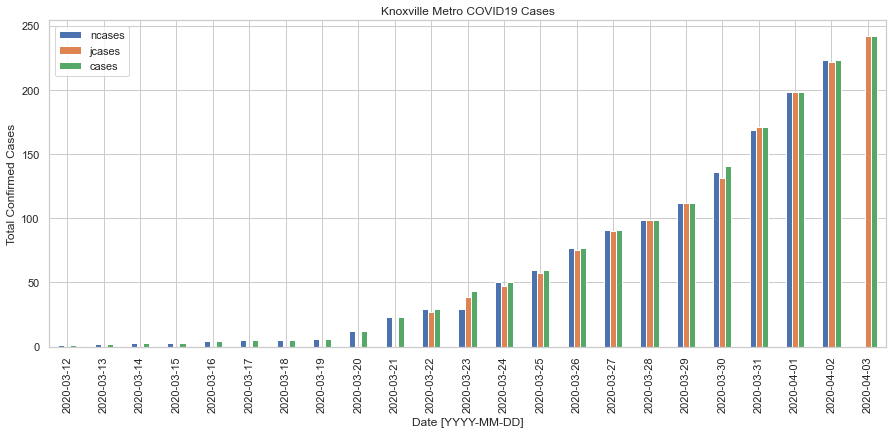

In [229]:
plt.figure(figsize=(14, 9))
case_series = knx_df.groupby(knx_df.date)[['ncases', 'jcases', 'cases']].sum()
case_series.plot(kind='bar')
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Total Confirmed Cases')
plt.title('Knoxville Metro COVID19 Cases')

Text(0.5, 1.0, 'Knoxville Metro COVID19 Cases')

<Figure size 1008x648 with 0 Axes>

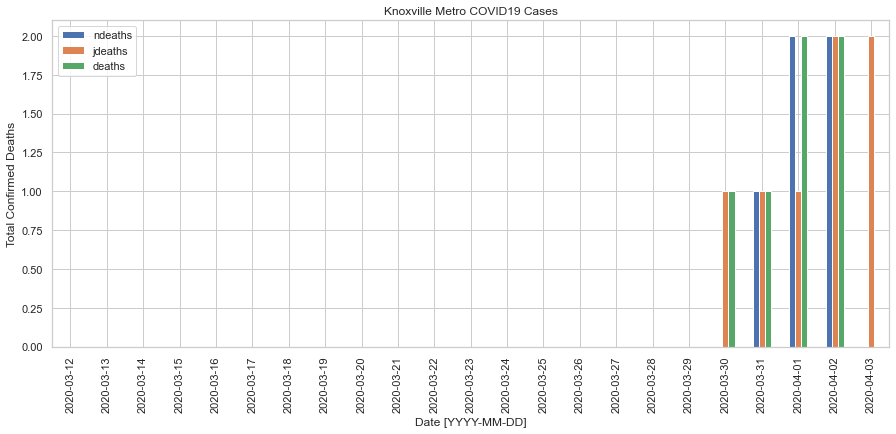

In [222]:
plt.figure(figsize=(14, 9))
case_series = knx_df.groupby(knx_df.date)[['ndeaths', 'jdeaths', 'deaths']].sum()
case_series.plot(kind='bar')
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Total Confirmed Deaths')
plt.title('Knoxville Metro COVID19 Cases')

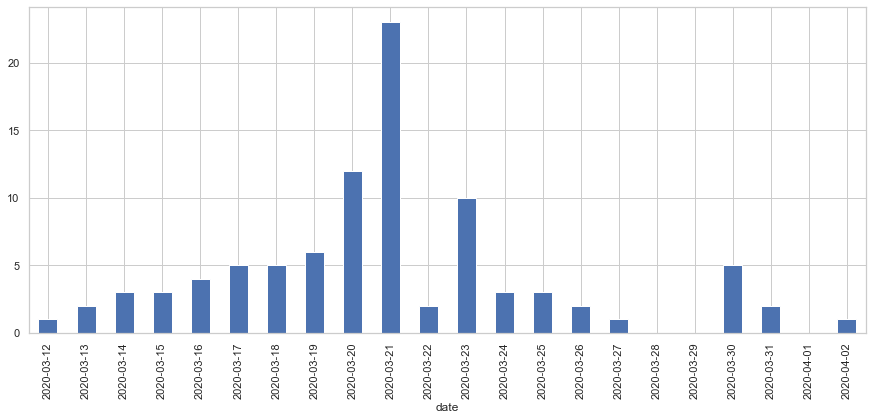

In [234]:
abs(case_series.ncases[:-1] - case_series.jcases[:-1]).plot(kind='bar')

# County Time Series

## Individual Counties

Text(0, -60, 'Data from The New York Times, based on reports from state and local health agencies.')

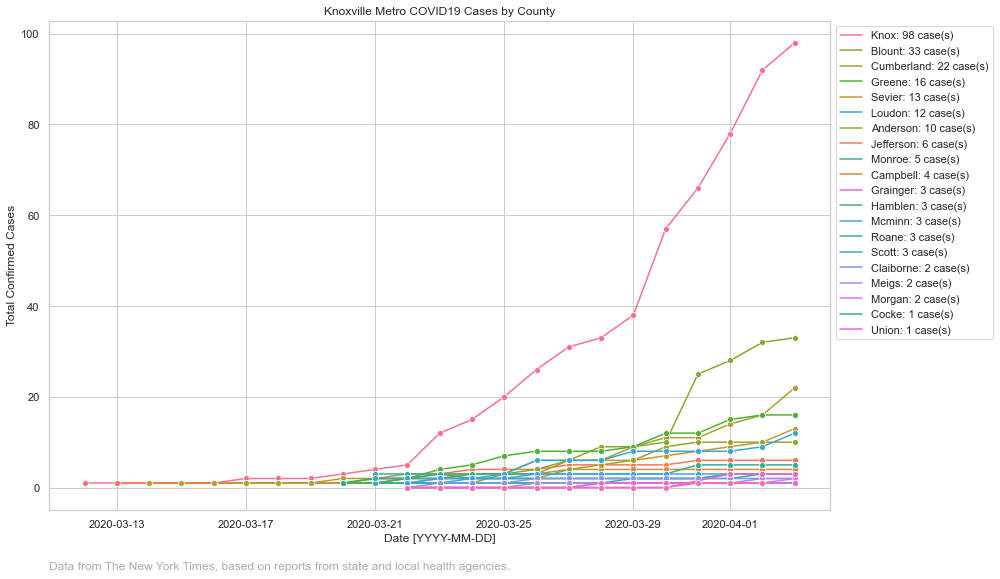

In [261]:
latest = knx_df[knx_df['date'] == knx_df['date'].max()].sort_values(by=['cases'], ascending=False)
latest = zip([x.lower() for x in latest['county'].unique()], [x for x in latest['cases']])

# plot cases per county per day
plt.figure(figsize=(14, 9))
fig = sns.lineplot(x='date',
                   y='cases',
                   hue='county',
                   markers=True,
                   marker='o',
                   dashes=False,
                   data=knx_df)
handles, labels = fig.get_legend_handles_labels()
legend_entries = {}
for lh in zip(labels, handles):
    legend_entries[lh[0].lower()] = lh[1]
labels = []
handles = []
for c in latest:
    labels.append(c[0].capitalize() + ': {:.0f} case(s)'.format(c[1]))
    handles.append(legend_entries[c[0]])
plt.legend(handles, labels, bbox_to_anchor=(1, 1), loc=2)
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Total Confirmed Cases')
plt.title('Knoxville Metro COVID19 Cases by County')
attribution = 'Data from The New York Times, based on reports from state and local health agencies.'
plt.annotate(attribution, (0, 0), (0, -60),
             xycoords='axes fraction',
             textcoords='offset points',
             fontsize=12, color='#000000', alpha=0.33)

## All Counties

Text(0.5, 1.0, 'Knoxville Metro COVID19 Cases')

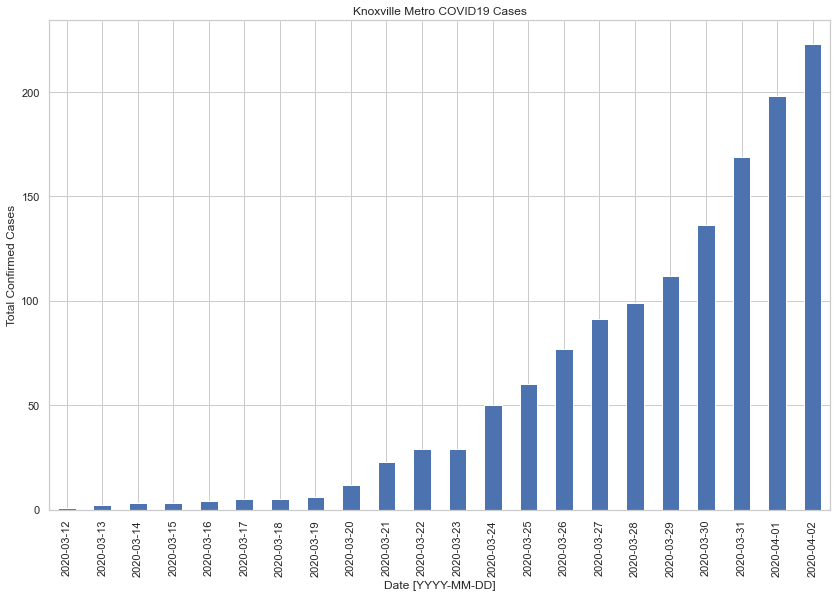

In [18]:
# plot aggregate cases per day for KNX metro
plt.figure(figsize=(14, 9))
case_series = knx_df.groupby(knx_df.date)['cases'].sum()
case_series.plot(kind='bar')
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Total Confirmed Cases')
plt.title('Knoxville Metro COVID19 Cases')

In [19]:
# define a logistic function
def logifunc(x, A, x0, k):
    return A / (1. + np.exp(-k * (x - x0)))

# select dates and cases as arrays
x = [n for n, _ in enumerate(case_series.index)]
y = case_series.values

# scale case number for fitting
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
y_scaled = y_scaled.reshape(1, -1)[0]

In [20]:
# use scipy opt to fit logistic
popt, pcov = opt.curve_fit(logifunc, x, y_scaled, maxfev=100000)
x_fit = np.linspace(0, 60, num=60)
y_fit = logifunc(x_fit, *popt)

# reverse the scaling
y_fit = y_fit.reshape(-1, 1)
y_fit = scaler.inverse_transform(y_fit).reshape(1, -1)[0]

In [21]:
knx_df = ny_times_df[ny_times_df['fips'].isin(knx_metro_fips)]
case_series = knx_df.groupby(knx_df.date.dt.date)['cases'].sum()
x = [n for n, _ in enumerate(case_series.index)]
y = case_series.values

In [22]:
basedate = case_series.index[0]
x = case_series.index
x_fit = np.array([basedate + dt.timedelta(days=i) for i in range(len(x_fit))])

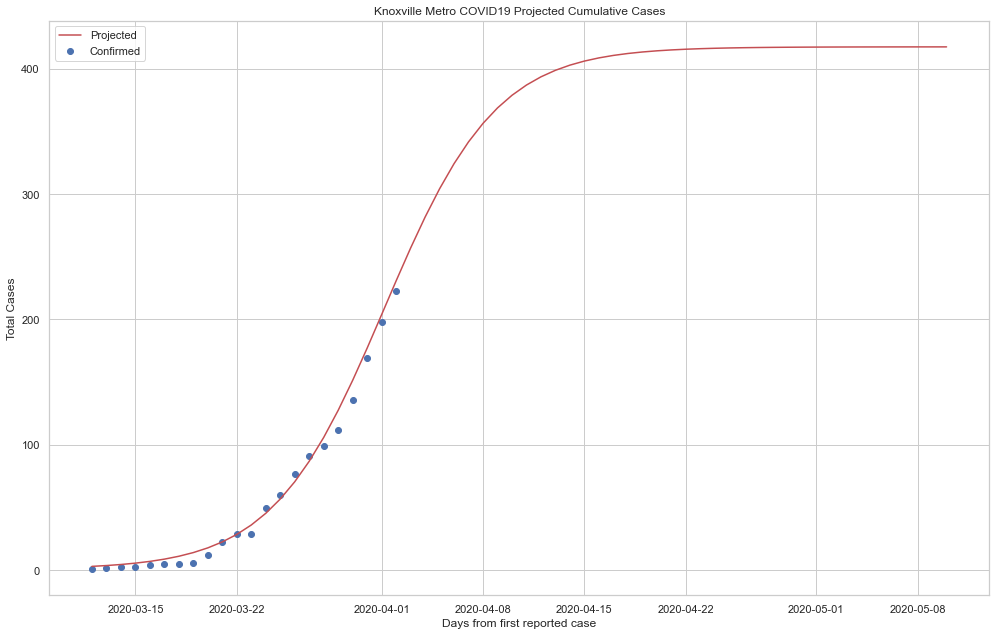

In [23]:
fig, ax = plt.subplots(figsize=(14, 9))
plt.scatter(x, y, label='Confirmed')
plt.plot(x_fit, y_fit, 'r-', label='Projected')
plt.legend()
plt.xlabel('Days from first reported case')
plt.ylabel('Total Cases')
plt.title('Knoxville Metro COVID19 Projected Cumulative Cases')
plt.tight_layout()

# Prophet

In [262]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

## daily cases

In [264]:
daily_cases = knx_df.groupby(knx_df.date)['cases'].sum().diff()
prophet_df = daily_cases.to_frame().reset_index().fillna(0)
prophet_df.columns = ['ds', 'y']
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


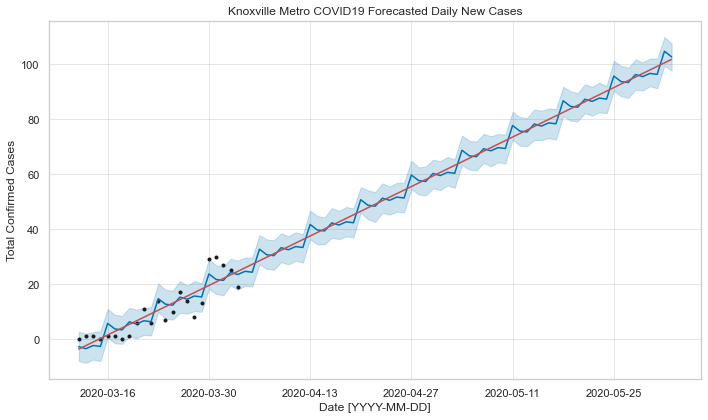

In [265]:
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Total Confirmed Cases')
plt.title('Knoxville Metro COVID19 Forecasted Daily New Cases')# -- Updated: {}'.format(time_now()))
plt.tight_layout()

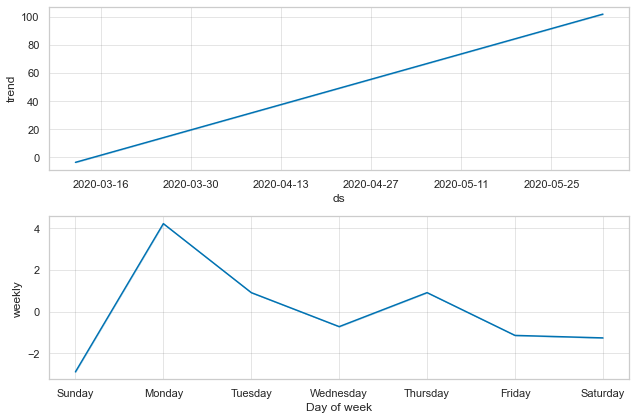

In [266]:
fig2 = m.plot_components(forecast)

In [267]:
fig = plot_plotly(m, forecast)
py.iplot(fig)

## Worst case

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

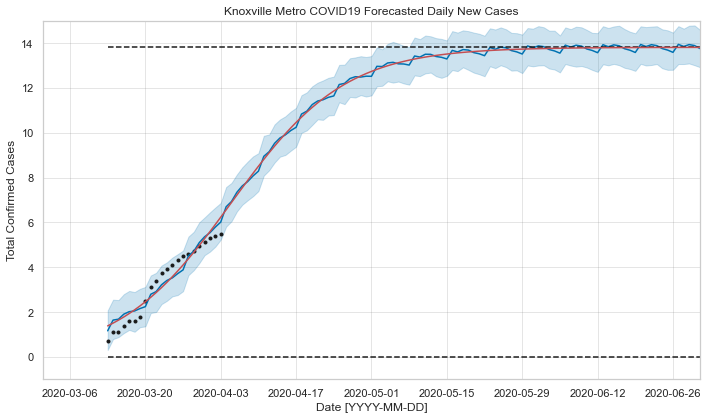

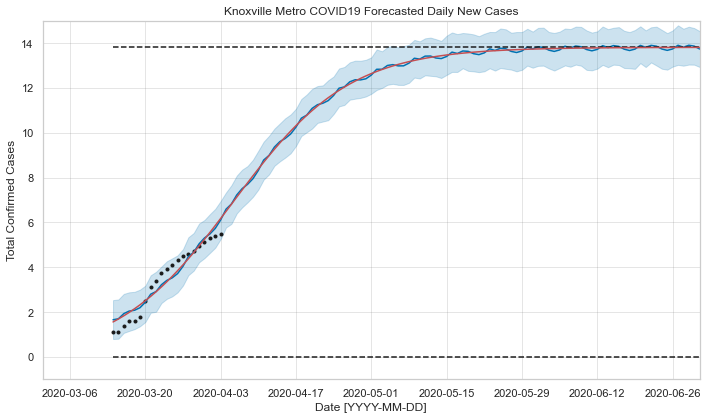

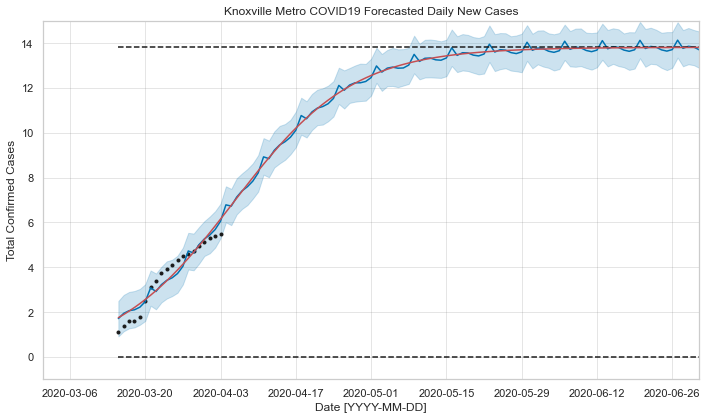

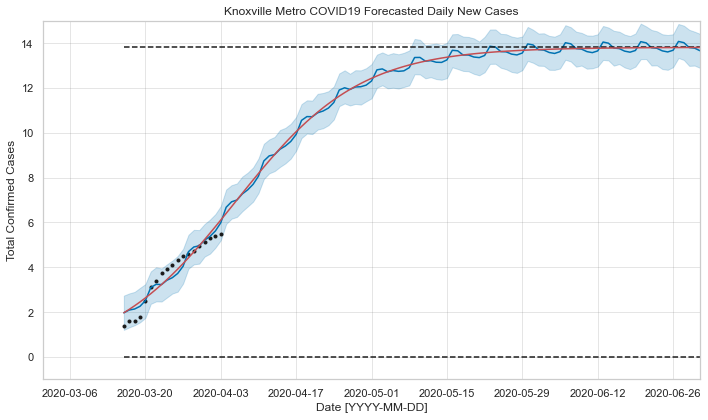

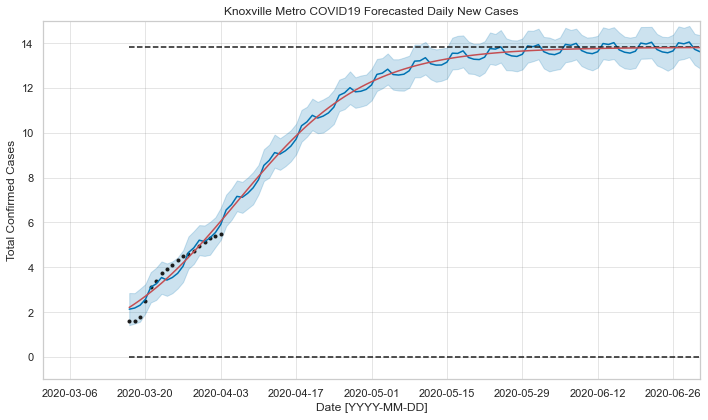

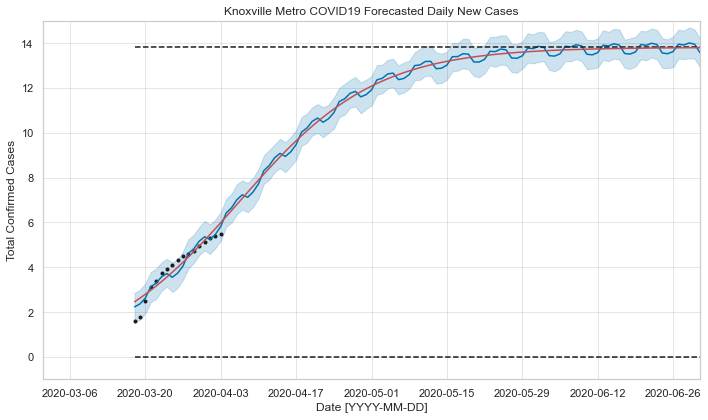

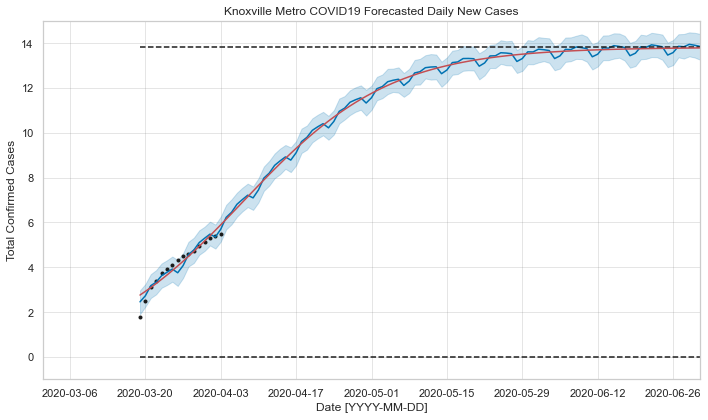

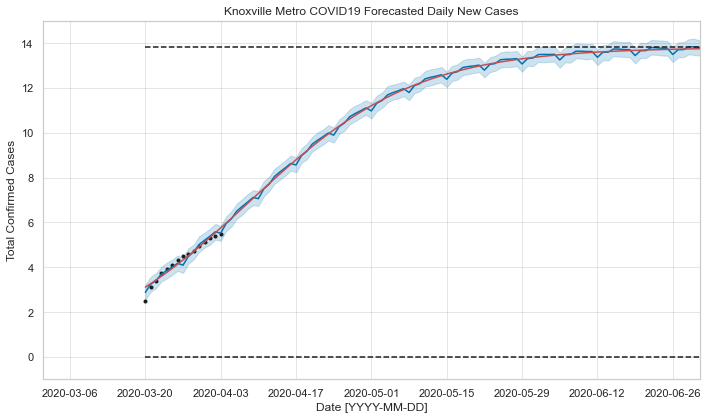

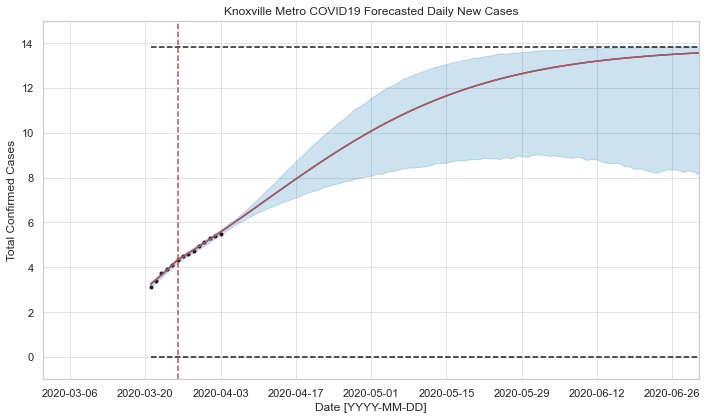

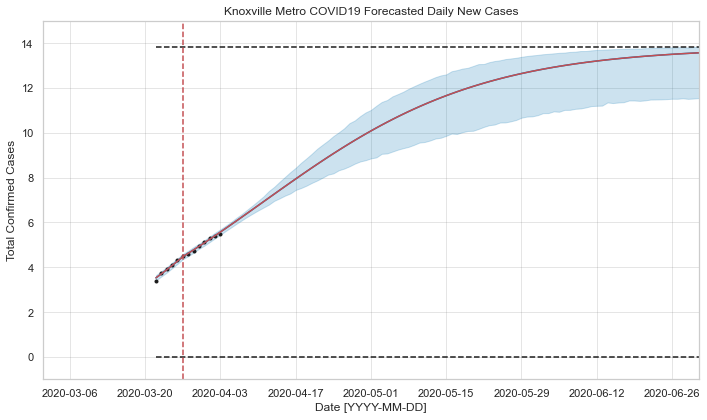

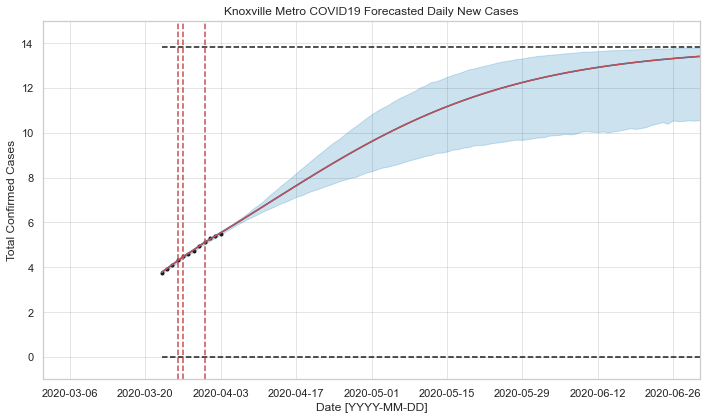

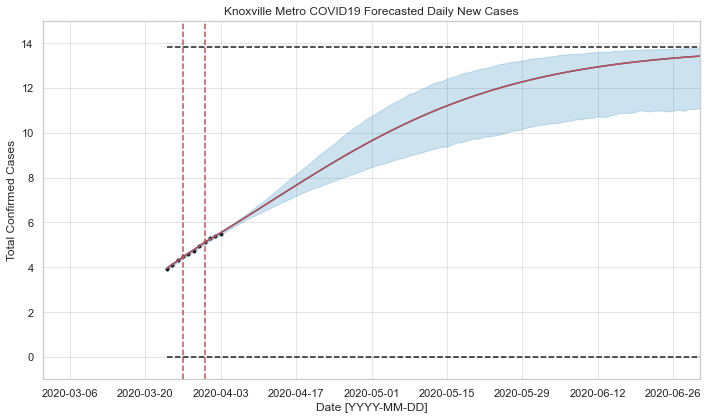

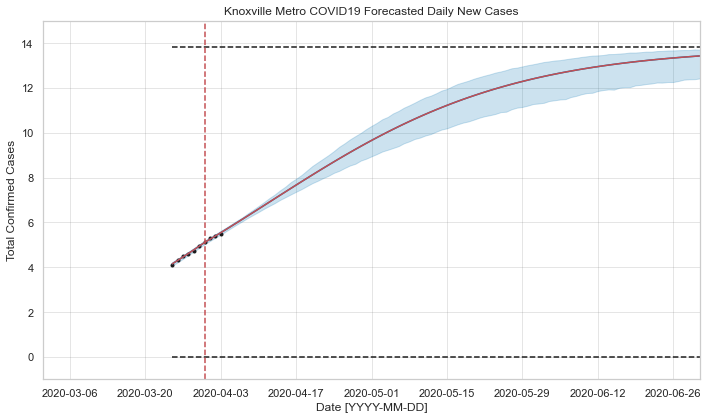

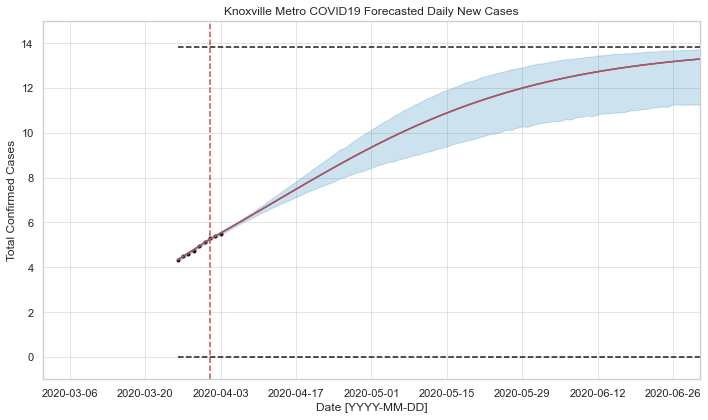

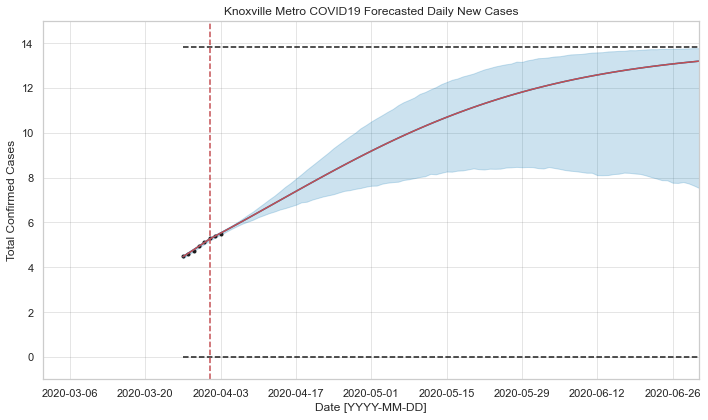

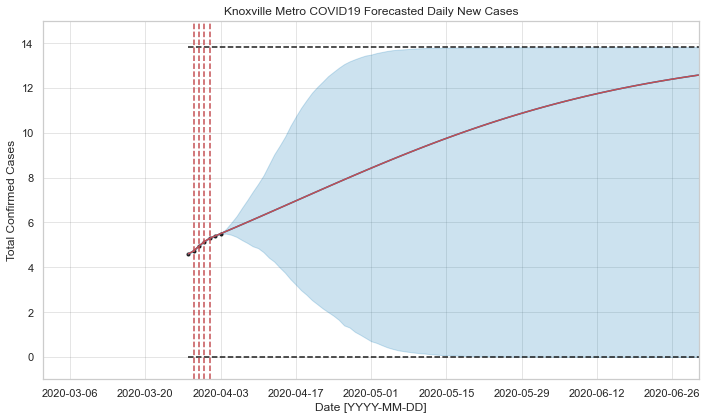

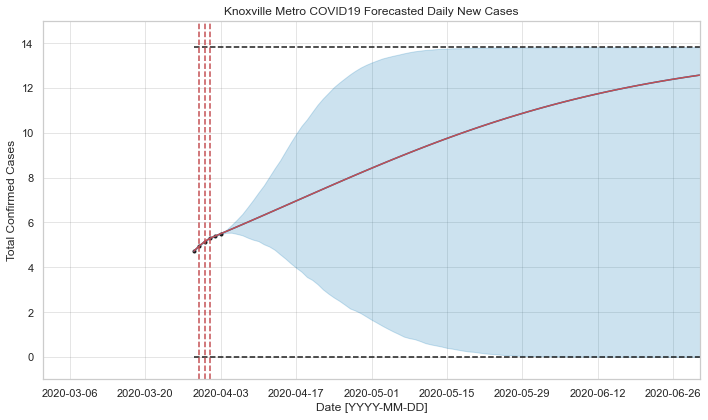

In [306]:
daily_cases = knx_df.groupby(knx_df.date)['cases'].sum()
j = round(0.75 * len(daily_cases))
prophet_df = daily_cases.iloc[i:].to_frame().reset_index().fillna(0)
prophet_df.columns = ['ds', 'y']
prophet_df['y'] = np.log(prophet_df['y'])
prophet_df = prophet_df.replace([np.inf, -np.inf], 0)
capacity = np.log(1e6)
prophet_df['cap'] = capacity
prophet_df['floor'] = 0.0

for i in range(0, j):
    ani_df = prophet_df.iloc[i:]
    m = Prophet(growth='logistic', interval_width=0.95)
    m.fit(ani_df)
    future = m.make_future_dataframe(periods=90)
    future['cap'] = capacity
    future['floor'] = 0.0
    forecast = m.predict(future)
    fig1 = m.plot(forecast)
    a = add_changepoints_to_plot(fig1.gca(), m, forecast)
    plt.xlabel('Date [YYYY-MM-DD]')
    plt.ylabel('Total Confirmed Cases')
    plt.xlim(dt.date(2020, 3, 1), dt.date(2020, 7, 1))
    plt.ylim(-1, 15)
    plt.title('Knoxville Metro COVID19 Forecasted Daily New Cases')# -- Updated: {}'.format(time_now()))
    plt.tight_layout()
    plt.savefig('../imgs/wc_{:04d}'.format(i))

In [314]:
# make an mp4 from png
!ffmpeg -framerate 2 -i ../imgs/wc_%04d.png -r 60 -vcodec copy -acodec copy -vcodec libx264 -pix_fmt yuv420p -y ../imgs/wc.mp4

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [315]:
# create a palette
!ffmpeg -i ../imgs/wc.mp4 -filter_complex "fps=2,scale=-1:640,setsar=1,palettegen" -y ../imgs/palette.png

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [316]:
# create the gif
!ffmpeg -i ../imgs/wc.mp4 -i ../imgs/palette.png -filter_complex "[0]fps=2,scale=-1:640,setsar=1[x];[x][1:v]paletteuse" -y ../imgs/wc.gif

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


# Progression

## MIDAS Value Estimates

In [32]:
# load midas param estimates
midas_datafile = os.path.join(datadir, 'midas/parameter_estimates/2019_novel_coronavirus/estimates.csv')
midas_params = pd.read_csv(midas_datafile)

midas_params.head()

# remove whitespace and lowercase everything
midas_params = midas_params.stack().str.replace(' ', '_').unstack()
midas_params = midas_params.stack().str.lower().unstack()

# progression model params
pm_params = {}

## Peer-reviewed Values

In [33]:
# select for peer reviewed values
midas_params_pr = midas_params.dropna(subset=['peer_review'])
midas_params_pr = midas_params_pr[midas_params_pr['peer_review'] == 'positive']

# R_0 -- https://en.wikipedia.org/wiki/Basic_reproduction_number
p = 'basic_reproduction_number'
pm_params['r0'] = float(midas_params_pr[midas_params_pr['name'] == p]['value'].max())

# incubation period -- https://en.wikipedia.org/wiki/Incubation_period
p = 'incubation_period'
pm_params['ip']= float(midas_params_pr[midas_params_pr['name'] == p]['value'].max())

# transmission rate -- https://en.wikipedia.org/wiki/Transmission_risks_and_rates
p = 'transmission_rate'
pm_params['tr']= float(midas_params_pr[midas_params_pr['name'] == p]['value'].min())

## Not Peer-reviewed Values

In [34]:
# select for not peer reviewed values
midas_params_npr = midas_params[midas_params['peer_review'] != 'positive']

# time from symptoms to Hospitalization (tr)
p = 'time_from_symptom_onset_to_hospitalization'
pm_params['soh']= midas_params_npr[midas_params_npr['name'] == p]['value'].astype('float').mean()

# those that go to icu (icu)
p = "proportion_of_hospitalized_cases_admitted_to_icu"
pm_params['icu']= midas_params_npr[midas_params_npr['name'] == p]['value'].astype('float').mean()

# case hospitalization rate (chr)
# percent confirmed cases requiring hospitalization: 15% (China)
# https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html
pm_params['chr'] = 0.20

## KNX Model

* https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca
* https://jamanetwork.com/journals/jama/fullarticle/2762130


1. Confirmed cases -- `c = knx_df['cases']`
3. Hospitalization -- `h = c * chr`
4. Admitted to ICU -- `i = h * icu`

Confirmed Cases --> Hospitalized: 0.2
Hospitalized --> ICU: 0.05
KNX Metro ICU capacity: 295
Critical case load: 29500.0


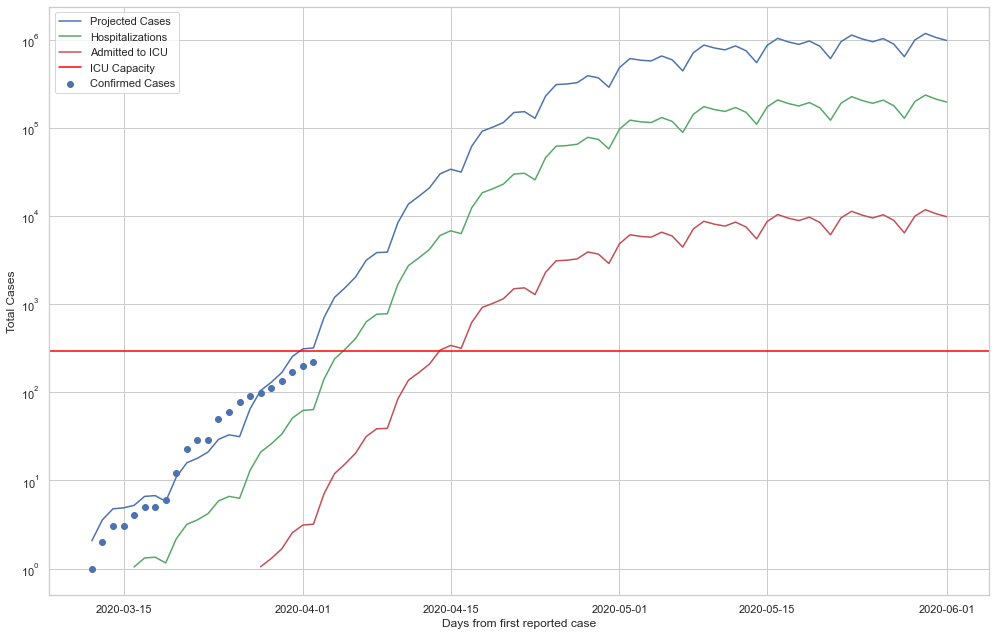

In [35]:
ds = forecast['ds']
yhat = np.exp(forecast['yhat'].values)

print('Confirmed Cases --> Hospitalized: {}'.format(pm_params['chr']))
print('Hospitalized --> ICU: {}'.format(pm_params['icu']))

hospitalized = yhat * pm_params['chr']
icu = hospitalized * pm_params['icu']
hospitalized = [x if x > 1 else np.nan for x in hospitalized]
icu = [x if x > 1 else np.nan for x in icu]

knx_icu_beds = knx_hospitals_df.icu_beds.sum()
print('KNX Metro ICU capacity: {}'.format(knx_icu_beds))
critical_mass = knx_icu_beds / pm_params['icu'] / pm_params['chr']
print('Critical case load: {}'.format(round(critical_mass, 0)))

x = case_series.index
y = case_series.values

fig, ax = plt.subplots(figsize=(14, 9))
plt.scatter(x, y, label='Confirmed Cases')
plt.plot(ds, yhat, 'b-', label='Projected Cases')
plt.plot(ds, hospitalized, 'g-', label='Hospitalizations')
plt.plot(ds, icu, 'r-', label='Admitted to ICU')
plt.axhline(y=knx_icu_beds, color='red', linestyle='-', label='ICU Capacity')
ax.set_yscale('log')
plt.legend()
plt.xlabel('Days from first reported case')
plt.ylabel('Total Cases')
plt.tight_layout()

In [32]:
day0 = knx_df[knx_df['deaths'] > 0].date.min()
print('Day0 in KNX: {}'.format(day0))

Day0 in KNX: 2020-04-01 00:00:00


In [34]:
day0 - dt.timedelta(days=pm_params['soh'])

Timestamp('2020-03-26 02:24:00')

# Scratch

In [35]:
with open('../data/tn/tn-hospitals.geojson') as f:
    j = json.load(f)
for i, f in enumerate(j['features']):
    if 'icu_beds' not in f['properties'].keys():
        j['features'][i]['properties']['icu_beds'] = np.nan
outfile = "a.json"
with open(outfile, 'w') as f:
    json.dump(j, f, indent=4)

In [36]:
pm_params

{'r0': 2.24, 'ip': 5.2, 'tr': 0.35, 'soh': 5.9, 'icu': 0.05, 'chr': 0.2}